In [2]:
!pip install groq
!pip install python-dotenv
!pip install feedparser textblob

  Using cached groq-1.0.0-py3-none-any.whl.metadata (16 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
Using cached groq-1.0.0-py3-none-any.whl (138 kB)
Using cached distro-1.9.0-py3-none-any.whl (20 kB)
  Using cached python_dotenv-1.2.1-py3-none-any.whl.metadata (25 kB)
Using cached python_dotenv-1.2.1-py3-none-any.whl (21 kB)
  Using cached feedparser-6.0.12-py3-none-any.whl.metadata (2.7 kB)
  Using cached textblob-0.19.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached sgmllib3k-1.0.0-py3-none-any.whl
  Using cached nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached regex-2026.1.15-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (40 kB)
Using cached feedparser-6.0.12-py3-none-any.whl (81 kB)
Using cached textblob-0.19.0-py3-none-any.whl (624 kB)
Using cached nltk-3.9.2-py3-none-any.whl (1.5 MB)
Using cached regex-2026.1.15-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (800 k

In [3]:
# import os

# cwd = os.getcwd()
# print(cwd)

# os.chdir("/home/jovyan/fm-assist-volume/practice_gpt/hands_on_for_gpt/agentic-hands-on") # Changes the current working directory
# print(os.getcwd())

# 1. Minimal Agent

This is our simplest “agent” using groq-api:

* Has a role
* Takes input
* Produces reasoning-based output

In [4]:
import os

from groq import Groq
from dotenv import load_dotenv

load_dotenv()
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

class SimpleAgent:
    def __init__(self, system_prompt):
        self.system_prompt = system_prompt

    def run(self, user_input):
        # use llm-client's chat completion service and models to generate a response
        response = client.chat.completions.create(
            model="llama-3.3-70b-versatile",
            messages=[
                {"role": "system", "content": self.system_prompt},
                {"role": "user", "content": user_input}
            ],
            temperature=0.2
        )
        return response.choices[0].message.content


agent = SimpleAgent(
    system_prompt="You are a helpful AI agent that reasons step by step."
)

print(agent.run("Explain Kafka vs API based communication"))

To explain Kafka vs API-based communication, let's break down each concept and compare them step by step.

**API-based Communication:**

1. **Definition:** API (Application Programming Interface) is a set of defined rules that enable different applications, systems, or services to communicate with each other.
2. **Request-Response Model:** API-based communication follows a request-response model, where a client (e.g., a web application) sends a request to a server, and the server responds with the requested data.
3. **Synchronous Communication:** API-based communication is typically synchronous, meaning that the client waits for the server's response before proceeding.
4. **Point-to-Point Communication:** API-based communication is often point-to-point, meaning that a single client communicates with a single server.
5. **Stateless:** API-based communication is typically stateless, meaning that each request contains all the necessary information to complete the request.

**Kafka-based C

# 2. Stateful Agent (Memory + Iterative Reasoning)

Now this agent:

* Remembers context
* Builds conversation state
* Can ask clarifying questions


### Response from the llm:

```
ChatCompletion(
    id='chatcmpl-c4554bf1-edd2-4c87-98c1-e4595aa5d831', 
    choices=[
        Choice(
            finish_reason='stop', 
            index=0, 
            logprobs=None, 
            message=ChatCompletionMessage(
                content="To help you decide between Kafka and API, ... and I'll help you make an informed decision!", 
                role='assistant', 
                annotations=None, 
                executed_tools=None, 
                function_call=None, 
                reasoning=None, 
                tool_calls=None
            )
        )
    ], 
    created=1769932176, 
    model='llama-3.3-70b-versatile', 
    object='chat.completion', 
    mcp_list_tools=None, 
    service_tier='on_demand', 
    system_fingerprint='fp_43d97c5965', 
    usage=CompletionUsage(
        completion_tokens=340, 
        prompt_tokens=56, 
        total_tokens=396, 
        completion_time=1.149168506, 
        completion_tokens_details=None, 
        prompt_time=0.002955258, 
        prompt_tokens_details=None, 
        queue_time=0.008930827, 
        total_time=1.152123764
    ), 
    usage_breakdown=None, 
    x_groq=XGroq(
        id='req_01kgc2ve1segyrev1pmj1b891k', 
        debug=None, 
        seed=831061670, 
        usage=None
    )
)
```

In [5]:
from groq import Groq
from pprint import pprint

client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

class MemoryAgent:
    def __init__(self, system_prompt):
        self.messages = [{"role": "system", "content": system_prompt}]

    def run(self, user_input):
        self.messages.append({"role": "user", "content": user_input})

        response = client.chat.completions.create(
            model="llama-3.3-70b-versatile",
            messages=self.messages,
            temperature=0.2
        )

        assistant_msg = response.choices[0].message.content
        
        # save the response into a memory building a new context
        self.messages.append({"role": "assistant", "content": assistant_msg})
        return assistant_msg


agent = MemoryAgent(
    system_prompt="You are a senior system design agent. Ask clarifying questions when needed."
)

print(agent.run("Help me choose Kafka vs API"))
print(agent.run("Downstream SLA is 4 hours\n"))
print(f"agent workflow as chat: \n")
pprint(agent.messages)

To help you choose between Kafka and API, I need to understand your use case a bit better. Can you please provide some context about your project?

Here are some clarifying questions to get started:

1. What type of data are you trying to transfer or process? Is it real-time data, batch data, or a mix of both?
2. What is the volume and velocity of the data? Are we talking about a small amount of data or a large-scale data pipeline?
3. What are the producers and consumers of the data? Are they internal microservices, external services, or a combination of both?
4. Do you need to handle events, messages, or requests? Are there any specific requirements for data ordering, deduplication, or guaranteed delivery?
5. What are your scalability, reliability, and fault-tolerance requirements?
6. Are there any specific technologies or frameworks you're already using or planning to use?

Once I have a better understanding of your requirements, I can help you decide whether Kafka, API, or a combina

# 3. Tool-Calling Agent (True “Agentic” Behavior)

Agent decides whether to call a tool or think. We can then:

* Parse structured JSON
* Holds memory (messages)
* Registers tools
* Runs agent loop (Loop until task completes)
* Executes tools
* Returns final answer

In [6]:
import json
from groq import Groq


class ToolAgent:
    def __init__(self, model="llama-3.3-70b-versatile"):
        self.client = Groq(api_key=os.environ.get("GROQ_API_KEY"))
        self.model = model

        self.messages = [
            {
                "role": "system",
                "content": (
                    "You are a senior system design agent.\n"
                    "- If information is missing, ask clarifying questions.\n"
                    "- If enough information is available, call the tool ONCE.\n"
                    "- After receiving tool output, provide a FINAL answer.\n"
                    "- Do NOT call tools again after a tool result."
                ) # system_prompt given at the start
            }
        ]
        
        # defining tool-schema clearly
        self.tools = [
            {
                "type": "function",
                "function": {
                    "name": "choose_transport",
                    "description": "Decide Kafka vs API based on system constraints",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "sla_hours": {"type": "integer"},
                            "volume": {"type": "integer"},
                            "push": {"type": "boolean"}
                        },
                        "required": ["sla_hours", "volume", "push"]
                    }
                }
            }
        ]

        self.tool_used = False  # 🔒 critical flag

    # --------------------
    # Tool implementation
    # --------------------
    def choose_transport(self, sla_hours: int, volume: int, push: bool) -> dict:
        if push and sla_hours >= 2 and volume >= 1000:
            return {
                "decision": "Kafka",
                "reason": "High volume, async SLA, push-based architecture"
            }
        return {
            "decision": "API",
            "reason": "Lower volume or synchronous requirement"
        }

    def _execute_tool(self, name: str, args: dict) -> dict:
        if name == "choose_transport":
            return self.choose_transport(**args)
        raise ValueError(f"Unknown tool: {name}")

    # --------------------
    # Agent loop
    # --------------------
    def run(self, user_input: str, max_steps: int = 5) -> str:
        self.messages.append({"role": "user", "content": user_input})
        
        # run agent on-loop to assist a conversation
        for step in range(max_steps):
            # use llm-client's chat completion service and models to generate a response
            response = self.client.chat.completions.create(
                model=self.model,
                messages=self.messages,
                # allowing tool usage at max once - this will ensure agent
                # doesn't try infinite tool calls
                tools=self.tools if not self.tool_used else None,
                tool_choice="auto" if not self.tool_used else "none",
                temperature=0
            )

            message = response.choices[0].message

            # 🔧 Tool call (only once)
            if message.tool_calls and not self.tool_used:
                self.tool_used = True

                tool_call = message.tool_calls[0]
                tool_name = tool_call.function.name
                tool_args = json.loads(tool_call.function.arguments)

                print(f"\n🔧 Tool called: {tool_name}({tool_args})")

                result = self._execute_tool(tool_name, tool_args)

                self.messages.append({
                    "role": "tool",
                    "tool_call_id": tool_call.id,
                    "content": json.dumps(result)
                })

            # ✅ Final answer
            else:
                self.messages.append({
                    "role": "assistant",
                    "content": message.content
                })
                return message.content

        raise RuntimeError("Agent did not completed within max steps")

In [7]:
agent = ToolAgent()

output = agent.run(
    "Push-based system, thousands of comparisons per run, "
    "downstream SLA is 4 hours"
)

print("\n✅ FINAL OUTPUT:\n", output)


🔧 Tool called: choose_transport({'push': True, 'sla_hours': 4, 'volume': 1000})

✅ FINAL OUTPUT:
 FINAL ANSWER: Based on the provided information, the recommended system design is Kafka. This is because Kafka is well-suited for handling high volumes of data, has an asynchronous SLA that can accommodate the 4-hour downstream SLA, and is designed for push-based architectures, making it a good fit for the described use case.


# $ Using Abstract Class to call multiple tools cleanly

## 1. Create a base class to define tools

In [8]:
from abc import ABC, abstractmethod

class BaseTool(ABC):
    name: str
    description: str

    @abstractmethod
    def schema(self) -> dict:
        """Return OpenAI/Groq-compatible tool schema"""

    @abstractmethod
    def run(self, **kwargs) -> dict:
        """Execute tool"""

## 2. Create each tool using abstract class

* Each tool should inherit and override base class functions
* This abstract class ensures that all the functional tools are written with uniformity

In [9]:
class ChooseTransportTool(BaseTool):
    name = "choose_transport"
    description = "Decide Kafka vs API based on system constraints"

    def schema(self) -> dict:
        return {
            "type": "function",
            "function": {
                "name": self.name,
                "description": self.description,
                "parameters": {
                    "type": "object",
                    "properties": {
                        "sla_hours": {"type": "integer"},
                        "volume": {"type": "integer"},
                        "push": {"type": "boolean"}
                    },
                    "required": ["sla_hours", "volume", "push"]
                }
            }
        }

    def run(self, sla_hours: int, volume: int, push: bool) -> dict:
        if push and sla_hours >= 2 and volume >= 1000:
            return {"transport": "Kafka"}
        return {"transport": "API"}

## 3. Create a tool registry to call all the tools

* Clean separation
* Single source of truth
* Easy extension

In [10]:
class ToolRegistry:
    def __init__(self, tools: list[BaseTool]):
        self._tools = {tool.name: tool for tool in tools}

    def schemas(self) -> list[dict]:
        """Expose all tool schemas to LLM"""
        return [tool.schema() for tool in self._tools.values()]

    def execute(self, name: str, args: dict) -> dict:
        if name not in self._tools:
            raise ValueError(f"Tool '{name}' not registered")
        return self._tools[name].run(**args)

## 4. Agent Using tool registry

In [11]:
class ToolAgent:
    def __init__(self, tool_registry, client, model):
        self.tool_registry = tool_registry
        self.client = client
        self.model = model
        self.tool_used = False

        self.messages = [
            {
                "role": "system",
                "content": (
                    "You are an expert agent. "
                    "Call at most one tool, then conclude."
                )
            }
        ]

    def run(self, user_input: str):
        self.messages.append({"role": "user", "content": user_input})

        response = self.client.chat.completions.create(
            model=self.model,
            messages=self.messages,
            tools=self.tool_registry.schemas(),
            tool_choice="auto",
            temperature=0
        )

        msg = response.choices[0].message

        if msg.tool_calls:
            call = msg.tool_calls[0]
            result = self.tool_registry.execute(
                call.function.name,
                json.loads(call.function.arguments)
            )

            self.messages.append({
                "role": "tool",
                "tool_call_id": call.id,
                "content": json.dumps(result)
            })

            final = self.client.chat.completions.create(
                model=self.model,
                messages=self.messages,
                temperature=0
            )

            return final.choices[0].message.content

        return msg.content

## 5. Run the agentic-frameowrk with multiple tools and memory

Why this design scales

* One abstract contract
* Self-contained tools
* Zero agent coupling
* Easy testing (tool.run() standalone)
* Auto-discoverable schemas
* Production-ready

> NOTE: This is exactly how internal agent platforms are structured (minus internal infra).

In [12]:
from groq import Groq
from tools import *

client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

# create a list of tools that you want our agent to use
tools = [
    ChooseTransportTool(),
    EstimateCostTool(),
    EstimateLatencyTool(),
    FetchNewsTool(),
    PlotTopicFrequencyTool(),
    AnalyzeSentimentTool(),
    # Add more tools here
]

# register all the tools to ToolRegistry
registry = ToolRegistry(tools)

# call the tool integrated agent for response generation task
agent = ToolAgent(
    tool_registry=registry,
    client=client,
    model="llama-3.3-70b-versatile"
)

print(agent.run("Push-based system, high volume, SLA 4 hours"))
print(agent.run("Give details for a payment gateway system and give me news on Paypal stock price with date"))

Based on the information provided, it seems like you're describing a system that requires a high-volume data processing solution with a Service Level Agreement (SLA) of 4 hours. Given the push-based nature and the need to handle high volumes of data within a specific time frame, utilizing Apache Kafka as the transport mechanism is a suitable choice.

Kafka is designed for high-throughput and provides low-latency, fault-tolerant, and scalable data processing. It's particularly useful in push-based systems where data is continuously being generated and needs to be processed in real-time or near real-time. Kafka's ability to handle high volumes of data and its reliability features make it a good fit for applications that have strict SLAs, such as the 4-hour window mentioned.

Therefore, the conclusion is that using Kafka as the transport mechanism is an appropriate decision for this scenario, given its capabilities in handling high-volume data streams and supporting the required SLA.
For 

In [23]:
agent.messages

[{'role': 'system',
  'content': 'You are an expert agent. Call at most one tool, then conclude.'},
 {'role': 'user', 'content': 'Push-based system, high volume, SLA 4 hours'},
 {'role': 'tool',
  'tool_call_id': 'zqx478n84',
  'content': '{"transport": "Kafka"}'},
 {'role': 'user',
  'content': 'Give details for a payment gateway system and give me news on Paypal stock price with date'},
 {'role': 'tool',
  'tool_call_id': 'g4g9cksgd',
  'content': '{"transport": "Kafka"}'},
 {'role': 'user',
  'content': 'Give me news on Paypal stock price with date and plot graph for last 1 year stock price'},
 {'role': 'user',
  'content': 'Give me news on Paypal stock price and plot graph for last 1 year stock price'},
 {'role': 'user',
  'content': 'Give me headline related to Target and Plot most frequent words in headlines'},
 {'role': 'tool',
  'tool_call_id': '8ver3995s',
  'content': '{"headlines": ["Target\\u2019s New C.E.O. Faces Hometown Crisis as He Begins Turnaround Effort - The New Yor

In [22]:
print(agent.run("Give me headline related to Target and Plot most frequent words in headlines"))

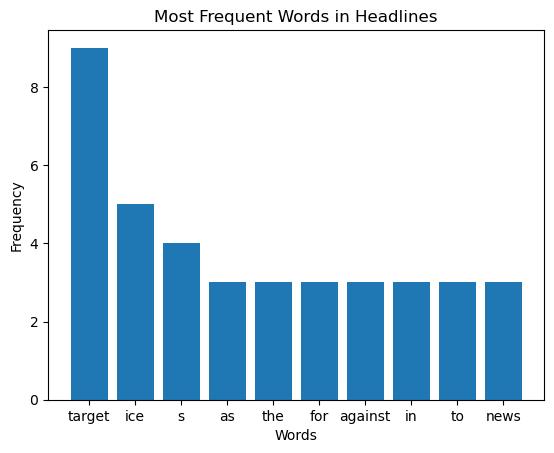

In [17]:
import matplotlib.pyplot as plt
from collections import Counter
import re

headlines = ["Target’s New C.E.O. Faces Hometown Crisis as He Begins Turnaround Effort - The New York Times", "Anti-ICE protesters call for national action against federal immigration tactics - NPR", "Demonstrators in Dinkytown call for Target to speak out against ICE - CBS News", "Target employees are stepping in where the company won't, as an ICE crackdown grips Minneapolis - Business Insider", "Seven detained outside West Loop Target as protesters demand retailer stand against ICE - Chicago Tribune", "Nottingham Forest agree deal for Stefan Ortega and target Davide Frattesi - BBC", "Campus Radicals: Dems target military school, Chicago teachers wreak havoc, college nurse's viral scandal - Fox News", "The Triangle’s newest Target store opens soon. Here’s when to go - News & Observer", "ICE eyeing Ohio next, where it is expected to target Haitian immigrants - MS NOW", "Target in Greece operating without running water - 13wham.com"]

words = []
for headline in headlines:
    words.extend(re.findall(r'\b\w+\b', headline.lower()))

word_freq = Counter(words)
most_common_words = word_freq.most_common(10)

words, freq = zip(*most_common_words)
plt.bar(words, freq)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Frequent Words in Headlines')
plt.show()

In [24]:
print(agent.run("Give me Analyze sentiment of text headlines"))

The average sentiment of the text headlines is 0.009, indicating a slightly positive sentiment.
